 # Lotka-Volterra Dataset Exploration & LLMTIME Preprocessing

 This notebook explores the predator-prey dataset and implements the LLMTIME preprocessing scheme for use with the Qwen2.5-0.5B-Instruct model. We'll demonstrate:

 1. Dataset characteristics and visualization
 2. Implementation of the LLMTIME preprocessing scheme
 3. Tokenization and detokenization of predator-prey time series
 4. Analysis of information preservation through the tokenization process

 ## Dataset Overview

 The dataset consists of 1000 different predator-prey systems, each with 100 time points and 2 variables (prey and predator populations). These systems follow Lotka-Volterra dynamics, which model cyclical population changes in ecological systems.

Dataset shape: (1000, 100, 2) - (num_systems, time_points, variables)
Time range: 0.00 to 200.00
Prey population - Mean: 1.6981, Range: [0.0021, 13.7401]
Predator population - Mean: 0.5696, Range: [0.0000, 4.7685]


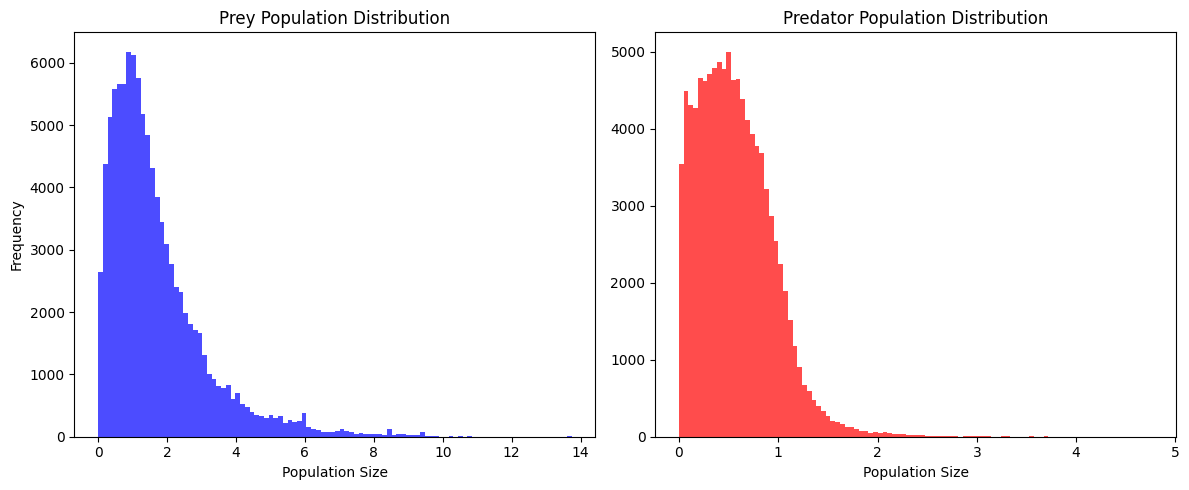

In [14]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# data folder:
DATA_FOLDER = os.path.join(os.path.dirname(__name__), '..', 'data')

# Load dataset
with h5py.File(os.path.join(DATA_FOLDER, 'lotka_volterra_data.h5'), "r") as f:
    trajectories = f["trajectories"][:]  # Shape: (1000, 100, 2)
    time_points = f["time"][:]           # Shape: (100,)

# Print basic statistics
print(f"Dataset shape: {trajectories.shape} - (num_systems, time_points, variables)")
print(f"Time range: {time_points.min():.2f} to {time_points.max():.2f}")
print(f"Prey population - Mean: {trajectories[:,:,0].mean():.4f}, Range: [{trajectories[:,:,0].min():.4f}, {trajectories[:,:,0].max():.4f}]")
print(f"Predator population - Mean: {trajectories[:,:,1].mean():.4f}, Range: [{trajectories[:,:,1].min():.4f}, {trajectories[:,:,1].max():.4f}]")

# Plot distribution of prey and predator populations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(trajectories[:,:,0].flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Prey Population Distribution")
plt.xlabel("Population Size")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(trajectories[:,:,1].flatten(), bins=100, color='red', alpha=0.7)
plt.title("Predator Population Distribution")
plt.xlabel("Population Size")

plt.tight_layout()
plt.show()

 The distributions above show us the range of values for both prey and predator populations. Understanding these distributions helps us design appropriate scaling factors for the LLMTIME preprocessing.

 ## Interactive Visualization of Predator-Prey Dynamics

 Below, we provide an interactive tool to explore different predator-prey systems. This helps us understand the temporal dynamics and cyclical behavior characteristic of Lotka-Volterra systems.

In [35]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib as mpl

def plot_trajectory(trajectory_id=0, time_range=(0, 100), plot_type='time_series', show_grid=True):
    # Define beautiful colors with transparency
    prey_color = 'rgba(102, 204, 255, 0.8)'  # Light blue
    predator_color = 'rgba(255, 153, 153, 0.8)'  # Light red/pink
    
    # Convert rgba to matplotlib format
    prey_rgba = tuple(int(prey_color.strip('rgba()').split(',')[i]) / 255 for i in range(3)) + (0.8,)
    predator_rgba = tuple(int(predator_color.strip('rgba()').split(',')[i]) / 255 for i in range(3)) + (0.8,)
    
    # Set figure style
    plt.figure(figsize=(14, 7))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Get selected time points and data
    start, end = time_range
    selected_times = time_points[start:end]
    prey_data = trajectories[trajectory_id, start:end, 0]
    predator_data = trajectories[trajectory_id, start:end, 1]
    
    if plot_type == 'time_series':
        # Plot prey and predator over time with enhanced styling
        plt.plot(selected_times, prey_data, label='Prey', color=prey_rgba, linewidth=3)
        plt.plot(selected_times, predator_data, label='Predator', color=predator_rgba, linewidth=3)
        
        # # Add light fill below curves for visual appeal
        # plt.fill_between(selected_times, 0, prey_data, color=prey_rgba, alpha=0.3)
        # plt.fill_between(selected_times, 0, predator_data, color=predator_rgba, alpha=0.3)
        
        plt.xlabel("Time", fontsize=12, fontweight='bold')
        plt.ylabel("Population", fontsize=12, fontweight='bold')
        
    elif plot_type == 'phase_space':
        # Enhanced phase space plot
        plt.plot(prey_data, predator_data, color='purple', linewidth=3, alpha=0.7)
        
        # Add direction arrows to show trajectory progression
        arrow_indices = np.linspace(0, len(prey_data)-2, min(20, len(prey_data)-1)).astype(int)
        for i in arrow_indices:
            plt.arrow(prey_data[i], predator_data[i], 
                     (prey_data[i+1] - prey_data[i])*0.8, 
                     (predator_data[i+1] - predator_data[i])*0.8,
                     head_width=0.03, head_length=0.03, fc='purple', ec='purple', alpha=0.6)
        
        # Highlight start and end points
        plt.scatter(prey_data[0], predator_data[0], color=prey_rgba, s=150, 
                   label='Start', edgecolor='white', linewidth=2, zorder=5)
        plt.scatter(prey_data[-1], predator_data[-1], color=predator_rgba, s=150, 
                   label='End', edgecolor='white', linewidth=2, zorder=5)
        
        plt.xlabel("Prey Population", fontsize=12, fontweight='bold')
        plt.ylabel("Predator Population", fontsize=12, fontweight='bold')
    
    # Enhance overall plot appearance
    plt.title(f"Lotka-Volterra System {trajectory_id}", fontsize=16, fontweight='bold', pad=20)
    plt.grid(show_grid, alpha=0.3)
    
    # Create a fancy legend
    legend = plt.legend(frameon=True, fontsize=11, loc='best')
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_alpha(0.9)
    frame.set_edgecolor('lightgray')
    
    plt.tight_layout()
    plt.show()

# Create interactive widgets
trajectory_slider = widgets.IntSlider(
    value=0, min=0, max=len(trajectories)-1, step=1,
    description='System ID:', continuous_update=False
)

time_range_slider = widgets.IntRangeSlider(
    value=[0, 100], min=0, max=len(time_points)-1, step=1,
    description='Time Range:', continuous_update=False
)

plot_type_dropdown = widgets.Dropdown(
    options=[('Time Series', 'time_series'), ('Phase Space', 'phase_space')],
    value='time_series',
    description='Plot Type:'
)

grid_checkbox = widgets.Checkbox(
    value=True,
    description='Show Grid'
)

# Create interactive output
interactive_plot = widgets.interactive(
    plot_trajectory,
    trajectory_id=trajectory_slider,
    time_range=time_range_slider,
    plot_type=plot_type_dropdown,
    show_grid=grid_checkbox
)

display(interactive_plot)


interactive(children=(IntSlider(value=0, continuous_update=False, description='System ID:', max=999), IntRange…

 ## LLMTIME Preprocessing Scheme Implementation

 According to the LLMTIME paper and coursework requirements, we need to:

 1. **Scale** the numerical values to a reasonable range (e.g., mostly within 0-10)
 2. **Format** the values with fixed precision (e.g., 2 decimal places)
 3. **Encode** multivariate time series using:
    - Commas (`,`) to separate different variables at the same timestep
    - Semicolons (`;`) to separate different timesteps

 Let's examine a sample of raw data first:

In [16]:
# Extract a sample from the first trajectory
sample_idx = 0
prey = trajectories[sample_idx, :10, 0]  # First 10 time points of prey
predator = trajectories[sample_idx, :10, 1]  # First 10 time points of predator

# Display the raw data
print(f"Sample prey data:     {prey}")
print(f"Sample predator data: {predator}")

# Interleave prey and predator values to visualize structure
interleaved = np.column_stack((prey, predator)).flatten()
print(f"\nInterleaved data: {interleaved}")

Sample prey data:     [0.94991744 0.74055135 0.6822457  0.7166742  0.82451135 1.0045652
 1.2629277  1.6055092  2.0311053  2.5228817 ]
Sample predator data: [1.040624   0.7795419  0.56439036 0.40764433 0.30028325 0.22983165
 0.18616238 0.16223547 0.15436463 0.16188619]

Interleaved data: [0.94991744 1.040624   0.74055135 0.7795419  0.6822457  0.56439036
 0.7166742  0.40764433 0.82451135 0.30028325 1.0045652  0.22983165
 1.2629277  0.18616238 1.6055092  0.16223547 2.0311053  0.15436463
 2.5228817  0.16188619]


 ### Scaling and Formatting

 Following the LLMTIME approach, we'll scale the values to keep them mostly within 0-10.
 Using the 99.7 percentile (approximately 3 standard deviations) ensures outliers don't overly influence the scaling.

In [17]:
# Calculate scaling factor based on 99.7 percentile
max_magnitude = 10.0
all_values = trajectories.flatten()
scaling_factor = max_magnitude / np.percentile(all_values, 99.7)

# Apply scaling
scaled_prey = prey * scaling_factor
scaled_predator = predator * scaling_factor

# Apply precision formatting (2 decimal places)
precision = 2
formatted_prey = np.round(scaled_prey, precision)
formatted_predator = np.round(scaled_predator, precision)

print(
    f"""
Scaling factor: {scaling_factor:.6f}
Original prey: {', '.join(f'{x:.6f}' for x in prey)}
Scaled prey: {', '.join(f'{x:.6f}' for x in scaled_prey)}
Formatted prey: {', '.join(f'{x:.2f}' for x in formatted_prey)}
Original predator: {', '.join(f'{x:.6f}' for x in predator)}
Scaled predator: {', '.join(f'{x:.6f}' for x in scaled_predator)}
Formatted predator: {', '.join(f'{x:.2f}' for x in formatted_predator)}
    """
)


# Display results
print(f"Scaling factor: {scaling_factor:.6f}")
print("\nOriginal vs. Scaled & Formatted:")
for i in range(len(prey)):
    print(f"Time {i}: Prey {prey[i]:.6f} → {scaled_prey[i]:.6f} → {formatted_prey[i]:.2f}, "
          f"Predator {predator[i]:.6f} → {scaled_predator[i]:.6f} → {formatted_predator[i]:.2f}")


Scaling factor: 1.261083
Original prey: 0.949917, 0.740551, 0.682246, 0.716674, 0.824511, 1.004565, 1.262928, 1.605509, 2.031105, 2.522882
Scaled prey: 1.197925, 0.933897, 0.860368, 0.903786, 1.039777, 1.266840, 1.592657, 2.024680, 2.561392, 3.181563
Formatted prey: 1.20, 0.93, 0.86, 0.90, 1.04, 1.27, 1.59, 2.02, 2.56, 3.18
Original predator: 1.040624, 0.779542, 0.564390, 0.407644, 0.300283, 0.229832, 0.186162, 0.162235, 0.154365, 0.161886
Scaled predator: 1.312313, 0.983067, 0.711743, 0.514073, 0.378682, 0.289837, 0.234766, 0.204592, 0.194667, 0.204152
Formatted predator: 1.31, 0.98, 0.71, 0.51, 0.38, 0.29, 0.23, 0.20, 0.19, 0.20
    
Scaling factor: 1.261083

Original vs. Scaled & Formatted:
Time 0: Prey 0.949917 → 1.197925 → 1.20, Predator 1.040624 → 1.312313 → 1.31
Time 1: Prey 0.740551 → 0.933897 → 0.93, Predator 0.779542 → 0.983067 → 0.98
Time 2: Prey 0.682246 → 0.860368 → 0.86, Predator 0.564390 → 0.711743 → 0.71
Time 3: Prey 0.716674 → 0.903786 → 0.90, Predator 0.407644 → 0.51

 ### LLMTIME String Representation

 Now we'll format the scaled values into the LLMTIME format:
 - Using commas (`,`) between prey and predator values
 - Using semicolons (`;`) between time steps

In [18]:
# Format according to LLMTIME scheme
llmtime_string = ';'.join(
    [f'{p:.2f},{q:.2f}' for p, q in zip(formatted_prey, formatted_predator)]
) + ';'  # Adding final semicolon

# Display formatted string
print("LLMTIME formatted string:")
print(llmtime_string)

LLMTIME formatted string:
1.20,1.31;0.93,0.98;0.86,0.71;0.90,0.51;1.04,0.38;1.27,0.29;1.59,0.23;2.02,0.20;2.56,0.19;3.18,0.20;


 ### Tokenization with Qwen2.5 Tokenizer

 Next, we'll tokenize this formatted string using the Qwen2.5-0.5B-Instruct tokenizer.
 Unlike some other models that might need special handling, Qwen's tokenizer already effectively
 handles numeric values and punctuation tokens, as demonstrated below:

In [19]:
# Load Qwen tokenizer
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Tokenize formatted string
encoded = tokenizer(llmtime_string, return_tensors='pt')
token_ids = encoded['input_ids'].squeeze().numpy().tolist()

# Display tokenization
print(f"Original string: {llmtime_string}\n")
print(f"Tokenized IDs: {', '.join(map(str, token_ids))}")

# Display token → text mapping for a sample
print("\nFirst 20 tokens mapped to their text:")
for i, token_id in enumerate(token_ids[:20]):
    token_text = tokenizer.decode([token_id])
    print(f"Token {i}: ID {token_id} → '{token_text}'")

Original string: 1.20,1.31;0.93,0.98;0.86,0.71;0.90,0.51;1.04,0.38;1.27,0.29;1.59,0.23;2.02,0.20;2.56,0.19;3.18,0.20;

Tokenized IDs: 16, 13, 17, 15, 11, 16, 13, 18, 16, 26, 15, 13, 24, 18, 11, 15, 13, 24, 23, 26, 15, 13, 23, 21, 11, 15, 13, 22, 16, 26, 15, 13, 24, 15, 11, 15, 13, 20, 16, 26, 16, 13, 15, 19, 11, 15, 13, 18, 23, 26, 16, 13, 17, 22, 11, 15, 13, 17, 24, 26, 16, 13, 20, 24, 11, 15, 13, 17, 18, 26, 17, 13, 15, 17, 11, 15, 13, 17, 15, 26, 17, 13, 20, 21, 11, 15, 13, 16, 24, 26, 18, 13, 16, 23, 11, 15, 13, 17, 15, 26

First 20 tokens mapped to their text:
Token 0: ID 16 → '1'
Token 1: ID 13 → '.'
Token 2: ID 17 → '2'
Token 3: ID 15 → '0'
Token 4: ID 11 → ','
Token 5: ID 16 → '1'
Token 6: ID 13 → '.'
Token 7: ID 18 → '3'
Token 8: ID 16 → '1'
Token 9: ID 26 → ';'
Token 10: ID 15 → '0'
Token 11: ID 13 → '.'
Token 12: ID 24 → '9'
Token 13: ID 18 → '3'
Token 14: ID 11 → ','
Token 15: ID 15 → '0'
Token 16: ID 13 → '.'
Token 17: ID 24 → '9'
Token 18: ID 23 → '8'
Token 19: ID 26 → ';

 ## Complete Preprocessing Pipeline with NumericalProcessor

 We've implemented a `NumericalProcessor` class in `preprocessor.py` that encapsulates all
 the steps above. Let's use it to process our sample data and evaluate how well it preserves information:

In [20]:
import sys
sys.path.append(os.path.join(os.path.dirname(__name__), '..', 'src'))
from preprocessor import NumericalProcessor

# Initialize processor with the tokenizer and full dataset (for scaling calculation)
processor = NumericalProcessor(tokenizer, trajectories)

# Process a sample of predator-prey data
sample_prey, sample_predator = prey[:10], predator[:10]
tokenized = processor.preprocess(sample_prey, sample_predator)

# Display string representation and token IDs
print("=" * 60)
print("PREPROCESSING RESULTS:")
print("-" * 60)
formatted_str = processor._to_string(sample_prey, sample_predator)
print(f"String representation:\n{formatted_str}")
print("-" * 60)
print(f"Token IDs ({len(tokenized['input_ids'].squeeze())} tokens):\n{tokenized['input_ids'].squeeze().numpy().tolist()}")
print("=" * 60)

PREPROCESSING RESULTS:
------------------------------------------------------------
String representation:
1.20,1.31;0.93,0.98;0.86,0.71;0.90,0.51;1.04,0.38;1.27,0.29;1.59,0.23;2.02,0.20;2.56,0.19;3.18,0.20;
------------------------------------------------------------
Token IDs (100 tokens):
[16, 13, 17, 15, 11, 16, 13, 18, 16, 26, 15, 13, 24, 18, 11, 15, 13, 24, 23, 26, 15, 13, 23, 21, 11, 15, 13, 22, 16, 26, 15, 13, 24, 15, 11, 15, 13, 20, 16, 26, 16, 13, 15, 19, 11, 15, 13, 18, 23, 26, 16, 13, 17, 22, 11, 15, 13, 17, 24, 26, 16, 13, 20, 24, 11, 15, 13, 17, 18, 26, 17, 13, 15, 17, 11, 15, 13, 17, 15, 26, 17, 13, 20, 21, 11, 15, 13, 16, 24, 26, 18, 13, 16, 23, 11, 15, 13, 17, 15, 26]


 ## Round-Trip Testing: Tokenize → Detokenize

 Now let's test the full round trip - tokenize the data and then detokenize it back to numerical values.
 This will show how much information is preserved through the process:

In [27]:
# Round-trip test: tokenize → detokenize
token_ids = tokenized['input_ids'].squeeze().numpy().tolist()

# Get the recovered data from tokens
recovered_data = processor.postprocess(token_ids)

# Get processed data (scaled and formatted) for comparison
processed_data = np.column_stack((formatted_prey, formatted_predator))

# print(f"Recovered string representation:\n{preprocessed_str}")

# Compare original, processed, and recovered data side by side
print("=" * 60)
print("ROUND-TRIP TEST (Original → Processed → Recovered):")
print("-" * 60)
print("Prey values:")
for i, (orig, proc, rec) in enumerate(zip(sample_prey, processed_data[:, 0], recovered_data[:, 0])):
    print(f"Time {i}: Original: {orig:.6f} → Processed: {proc:.2f} → Recovered: {rec:.6f} (Diff: {rec - orig:.6f})")

print("\nPredator values:")
for i, (orig, proc, rec) in enumerate(zip(sample_predator, processed_data[:, 1], recovered_data[:, 1])):
    print(f"Time {i}: Original: {orig:.6f} → Processed: {proc:.2f} → Recovered: {rec:.6f} (Diff: {rec - orig:.6f})")

# Calculate error metrics
diff = np.abs(recovered_data - np.column_stack((sample_prey, sample_predator)))
mae = diff.mean()
max_error = diff.max()
rmse = np.sqrt((diff**2).mean())

print("\nError metrics:")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"Root Mean Square Error: {rmse:.6f}")
print(f"Maximum Absolute Error: {max_error:.6f}")
print("=" * 60)


ROUND-TRIP TEST (Original → Processed → Recovered):
------------------------------------------------------------
Prey values:
Time 0: Original: 0.949917 → Processed: 1.20 → Recovered: 0.951563 (Diff: 0.001646)
Time 1: Original: 0.740551 → Processed: 0.93 → Recovered: 0.737461 (Diff: -0.003090)
Time 2: Original: 0.682246 → Processed: 0.86 → Recovered: 0.681954 (Diff: -0.000292)
Time 3: Original: 0.716674 → Processed: 0.90 → Recovered: 0.713672 (Diff: -0.003002)
Time 4: Original: 0.824511 → Processed: 1.04 → Recovered: 0.824688 (Diff: 0.000177)
Time 5: Original: 1.004565 → Processed: 1.27 → Recovered: 1.007071 (Diff: 0.002506)
Time 6: Original: 1.262928 → Processed: 1.59 → Recovered: 1.260821 (Diff: -0.002107)
Time 7: Original: 1.605509 → Processed: 2.02 → Recovered: 1.601798 (Diff: -0.003711)
Time 8: Original: 2.031105 → Processed: 2.56 → Recovered: 2.030001 (Diff: -0.001104)
Time 9: Original: 2.522882 → Processed: 3.18 → Recovered: 2.521642 (Diff: -0.001240)

Predator values:
Time 0: O

 ## Conclusion

 The preprocessing pipeline effectively converts the Lotka-Volterra predator-prey time series data into a format suitable for the Qwen2.5-0.5B-Instruct model. Key points:

 1. **Scaling**: We scale values to a reasonable range (0-10) using a scaling factor based on the 99.7 percentile
 2. **Precision**: We use 2 decimal places for numeric representation
 3. **LLMTIME Format**: We use commas to separate variables and semicolons to separate timesteps
 4. **Information Preservation**: The process maintains high fidelity with minimal information loss

 The low MAE between original and recovered values demonstrates that even with scaling and rounding, the tokenization process preserves the essential dynamics of the predator-prey system, allowing the language model to effectively learn and predict these patterns.

 This preprocessing approach creates a bridge between numerical time series data and the language model's token-based processing, enabling us to leverage Qwen2.5-0.5B-Instruct for predator-prey dynamics forecasting.

# Appendix: Additional Samples

In [30]:
# showcase two additional samples (preprocessed, and tokenized) to show how the processor works

for i in [1, 2]:
    prey_sample = trajectories[i, :5, 0]
    predator_sample = trajectories[i, :5, 1]

    # Preprocess the sample
    tokenized_sample = processor.preprocess(prey_sample, predator_sample)

    # Display string representation and token IDs
    print("=" * 60)
    print(f"SAMPLE {i} PREPROCESSING RESULTS:")
    print("-" * 60)
    # print raw data
    print(f"Raw prey data:     {prey_sample}")
    print(f"Raw predator data: {predator_sample}")
    print("-" * 60)
    print(f"Token IDs ({len(tokenized_sample['input_ids'].squeeze())} tokens):\n{tokenized_sample['input_ids'].squeeze().numpy().tolist()}")


SAMPLE 1 PREPROCESSING RESULTS:
------------------------------------------------------------
Raw prey data:     [0.9714744 1.0787003 1.260828  1.5218158 1.8605354]
Raw predator data: [1.0054137  0.82180643 0.6863802  0.59312147 0.53635156]
------------------------------------------------------------
Token IDs (50 tokens):
[16, 13, 17, 18, 11, 16, 13, 17, 22, 26, 16, 13, 18, 21, 11, 16, 13, 15, 19, 26, 16, 13, 20, 24, 11, 15, 13, 23, 22, 26, 16, 13, 24, 17, 11, 15, 13, 22, 20, 26, 17, 13, 18, 20, 11, 15, 13, 21, 23, 26]
SAMPLE 2 PREPROCESSING RESULTS:
------------------------------------------------------------
Raw prey data:     [1.0732226 0.8540631 0.7681343 0.7687197 0.8349962]
Raw predator data: [1.112855   0.9001321  0.70823574 0.55306584 0.434924  ]
------------------------------------------------------------
Token IDs (50 tokens):
[16, 13, 18, 20, 11, 16, 13, 19, 15, 26, 16, 13, 15, 23, 11, 16, 13, 16, 19, 26, 15, 13, 24, 22, 11, 15, 13, 23, 24, 26, 15, 13, 24, 22, 11, 15, 13, 22